In [411]:
import numpy as np
import pandas as pd
import torch
device = torch.device("mps")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
pop = pd.read_csv('data/songs_liwc_25_04_11_full_narrative.csv').iloc[:, 2:]
pop.columns

Index(['artist', 'album', 'song', 'lyrics', 'cleaned_lyrics', 'Segment', 'WC',
       'Analytic', 'Clout', 'Authentic',
       ...
       'PlotProg_1', 'PlotProg_2', 'PlotProg_3', 'PlotProg_4', 'PlotProg_5',
       'CogTension_1', 'CogTension_2', 'CogTension_3', 'CogTension_4',
       'CogTension_5'],
      dtype='object', length=146)

In [421]:
torch.backends.mps.is_available()
torch.backends.mps.is_built()
device

device(type='mps')

In [422]:
# processing: currently leaving punctuation alone
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

pop['lyrics'] = pop['lyrics'].astype(str).apply(remove_stopwords)
pop['lyrics-tokenized'] = pop['lyrics'].apply(simple_preprocess)


In [424]:
# emotion detection with distilroberta
# https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
# Load model and tokenizer

from transformers import pipeline
emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    device="mps"
)

# Process the entire column in batch (more efficient than applying row by row)
predictions = emotion_model(pop['lyrics'].tolist(), batch_size=8)

#print(predictions[:3])


In [425]:
# Extract only the emotion label from each prediction
pop['emotion'] = [pred['label'] for pred in predictions]  # Extract emotion labels
pop['emotion_score'] = [pred['score'] for pred in predictions]  # Extract confidence scores


In [426]:
# add NRC
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
from nrclex import NRCLex

#google ai popup:
def analyze_emotion(text):
    if isinstance(text, str):
        emotion_lexicon = NRCLex(text)
        return emotion_lexicon.raw_emotion_scores
    else:
        return {} 

#pop = pop.join(pop['emotion_scores'].apply(pd.Series))
pop['emotion_scores'] = pop['lyrics'].apply(analyze_emotion)

In [427]:
pop = pop.join(pop['emotion_scores'].apply(pd.Series).add_prefix("nrc_"))

In [428]:
pop.columns

Index(['artist', 'album', 'song', 'lyrics', 'cleaned_lyrics', 'Segment', 'WC',
       'Analytic', 'Clout', 'Authentic',
       ...
       'nrc_trust', 'nrc_anticipation', 'nrc_fear', 'nrc_surprise',
       'nrc_negative', 'nrc_disgust', 'nrc_sadness', 'nrc_joy', 'nrc_positive',
       'nrc_anger'],
      dtype='object', length=159)

In [429]:
# work on PCA -- have distilbert, NRC + LIWC

pop.to_csv('data/songs_expanded_25_04_11.csv', index=False)

In [430]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_scale =  pop.select_dtypes(include='number').fillna(0)
scl = pd.DataFrame(scaler.fit_transform(pop_scale)) 

In [431]:
scl.columns = pop_scale.columns
scl.head()


Segment        WC  Analytic     Clout  Authentic      Tone       WPS  \
0      0.0 -0.618155  0.873057  1.201296   1.038364 -0.292645 -0.707865   
1      0.0 -0.460551 -0.634646  1.793907  -1.289670  2.181485 -0.722951   
2      0.0  0.252608  1.561161 -0.972845   1.038364 -0.825438  1.864870   
3      0.0 -0.212324  0.150585 -0.649654   0.526037  0.048649  1.180200   
4      0.0 -0.180803  0.224924  1.655925   0.965450 -0.095142 -0.278089   

   BigWords       Dic  Linguistic  ...  nrc_trust  nrc_anticipation  nrc_fear  \
0  1.591334  0.278223    0.350093  ...  -0.684493         -0.435191 -0.164384   
1  0.138202  0.464881    0.885949  ...   0.189022         -0.057011 -0.875564   
2 -0.596957  0.475012    0.582310  ...  -0.434917         -0.309131  0.343602   
3 -0.409825  0.296950    0.510154  ...  -0.559705         -0.687311 -0.570773   
4 -0.184504  0.448610    0.735778  ...  -0.559705         -0.687311 -0.570773   

   nrc_surprise  nrc_negative  nrc_disgust  nrc_sadness   nrc_joy  \
0     -0.422965     -0.366940    -0.259091    -0.473287 -0.716367   
1      0.251083     -0.832875    -0.602675    -0.922087 -0.123798   
2     -0.759989     -0.034130    -0.259091     0.648712 -0.716367   
3     -0.591477     -0.034130    -0.717203    -0.585487  0.172487   
4     -0.422965     -0.233816    -0.373619    -0.024488 -0.716367   

   nrc_positive  nrc_anger  
0     -0.869461  -0.528881  
1     -0.492082  -0.714014  
2     -0.492082  -0.158613  
3     -0.869461  -0.343747  
4     -0.793985  -0.528881  

[5 rows x 150 columns]

In [432]:
#https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Principal%20Component%20Analysis.ipynb 
#from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pop_pca = pca.fit(scl)

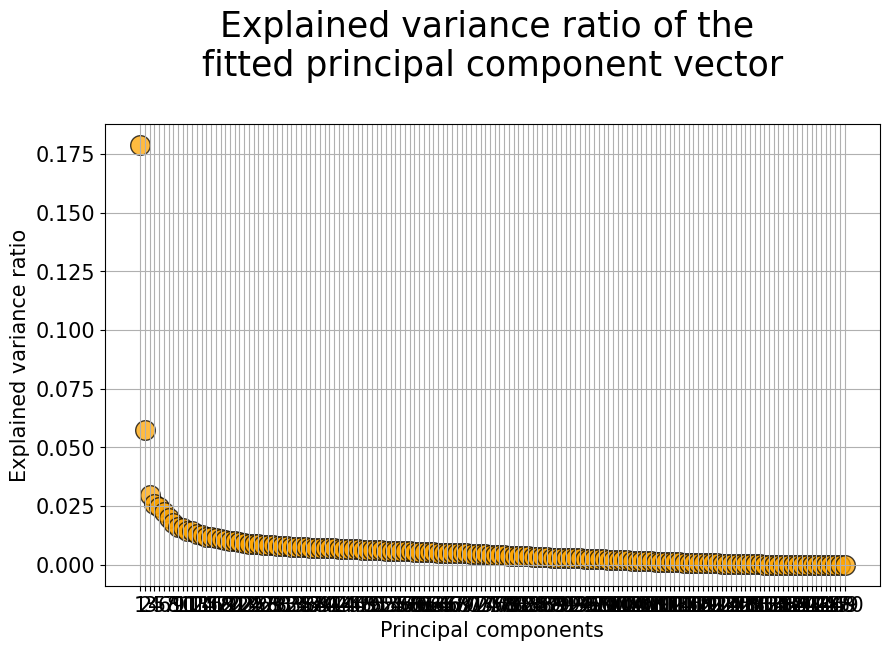

In [433]:
# explained variance ratio 
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pop_pca.explained_variance_ratio_))],
            y=pop_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(pop_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [434]:
pop_pca_trans = pd.DataFrame(pca.transform(scl))


[pca] >Extracting column labels from dataframe.
[pca] >The PCA reduction is performed on the [150] columns of the input dataframe.
[pca] >Fit using PCA.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled on

[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


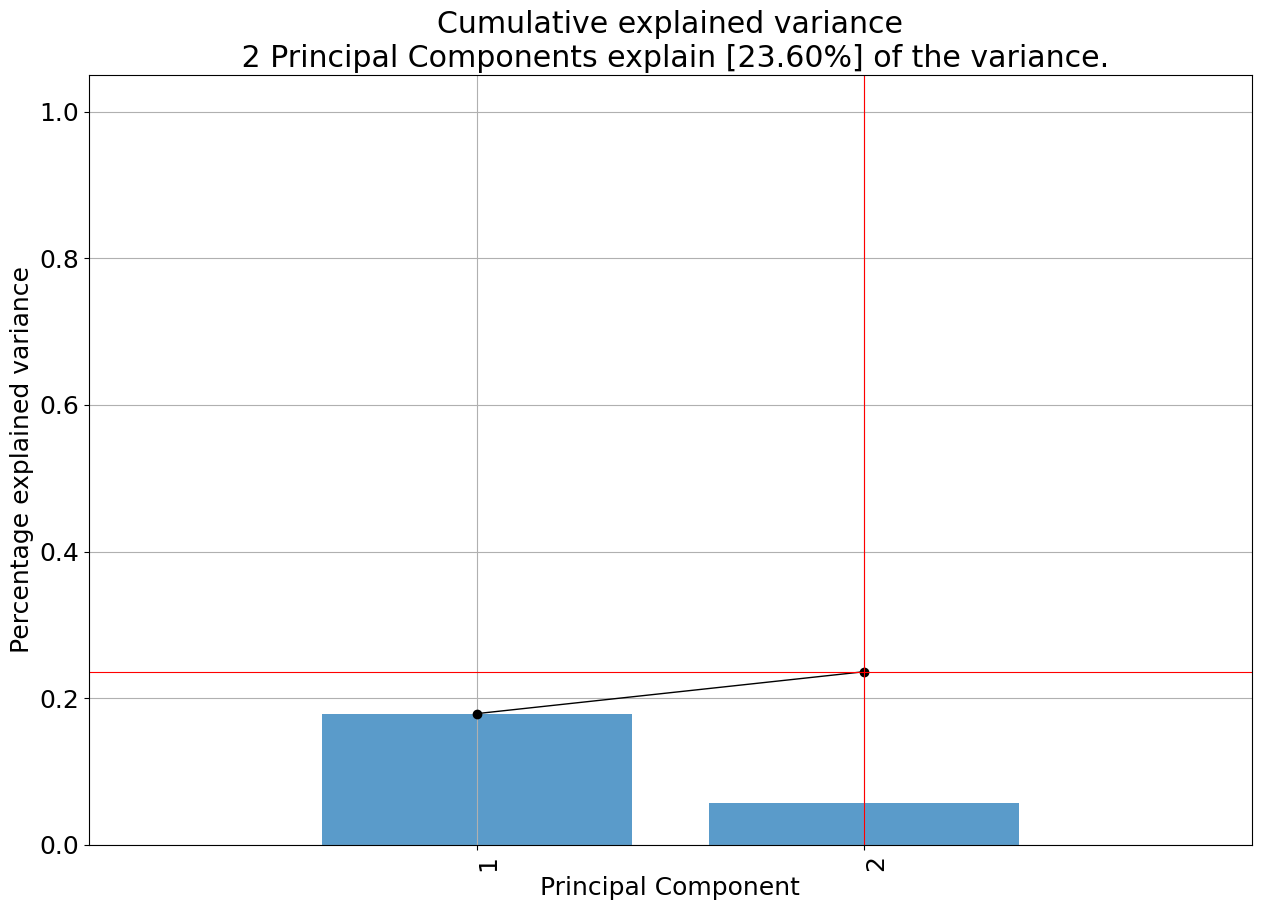

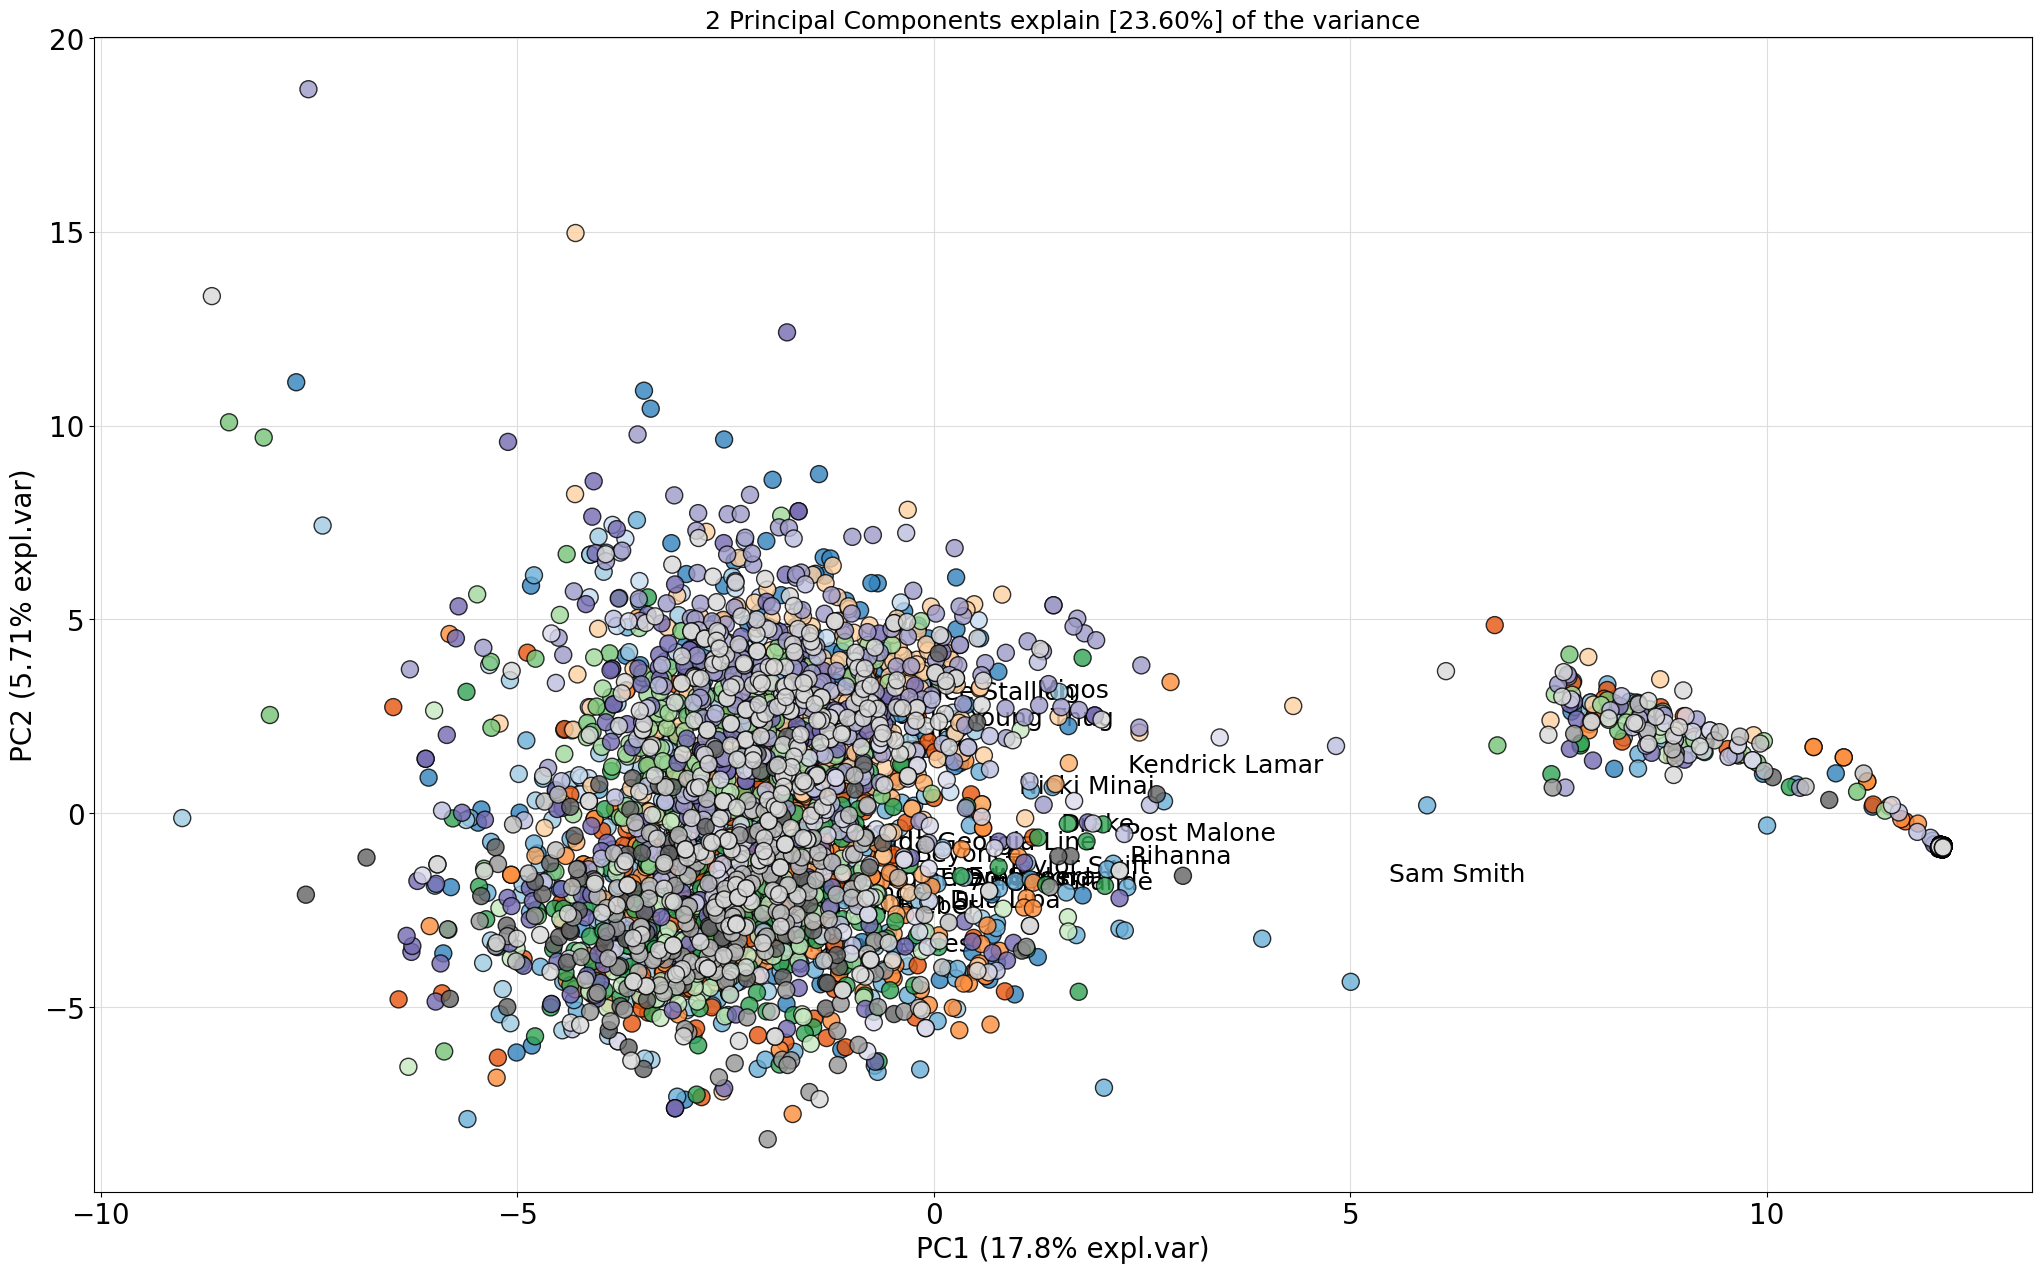

In [436]:
#https://erdogant.github.io/pca/pages/html/index.html
from pca import pca
#model = pca(n_components=0.95)
# ... or explicitly specify the number of PCs
model = pca(n_components=2)

# Fit and transform
results = model.fit_transform(X=scl, row_labels = pop["artist"])

# Plot the explained variance
fig, ax = model.plot()

# Scatter the first two PCs
fig, ax = model.scatter()



[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd] >INFO> Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[scatterd]

[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


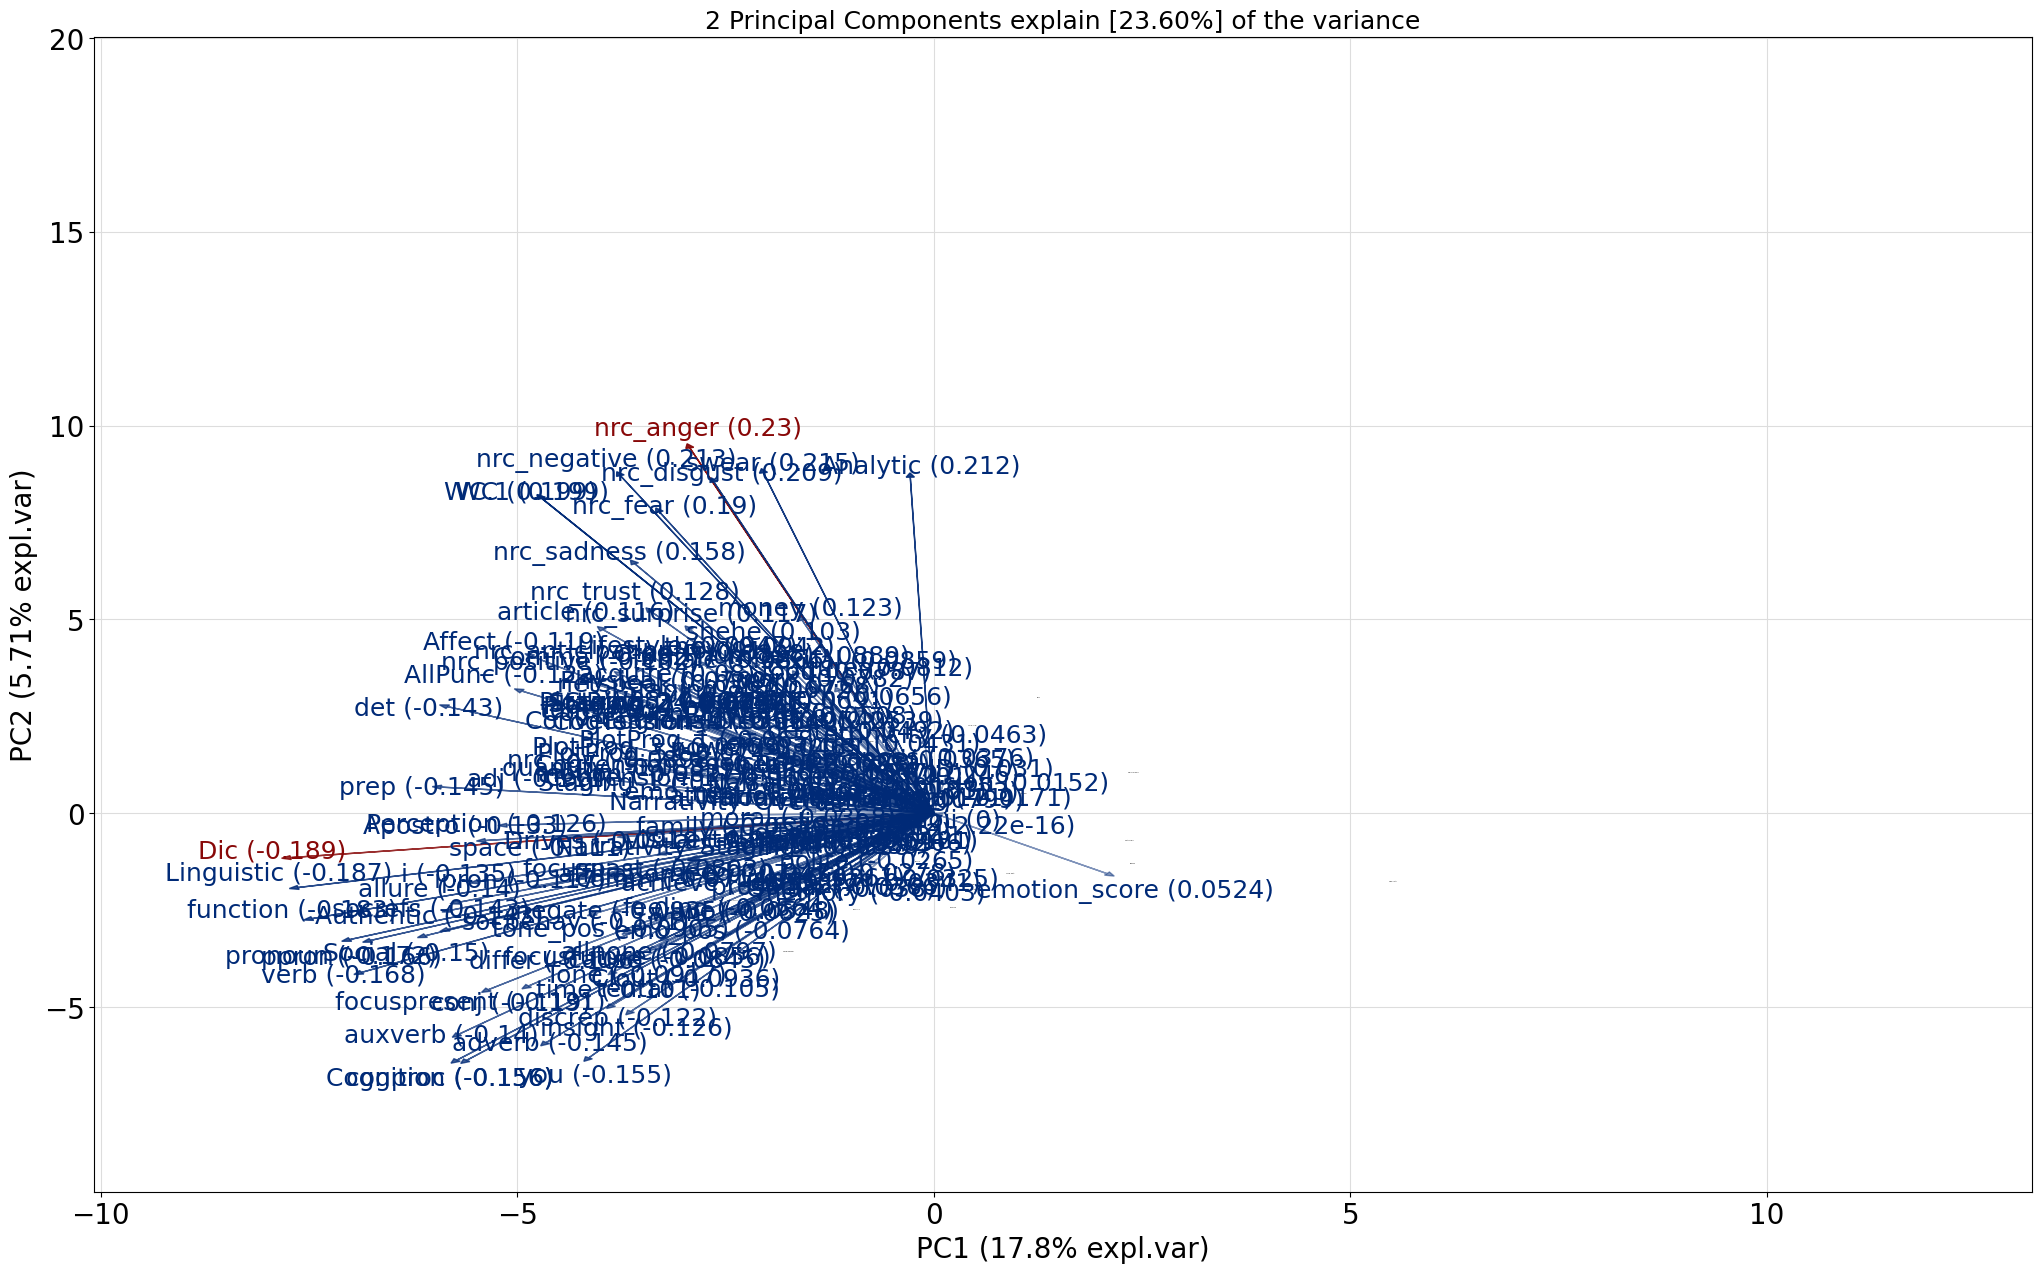

In [438]:
# Create a biplot
fig, ax = model.biplot(n_feat=150, cmap=None)


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0       Imagine Dragons
1       Imagine Dragons
2       Imagine Dragons
3       Imagine Dragons
4       Imagine Dragons
             ...       
3995        Nicki Minaj
3996        Nicki Minaj
3997        Nicki Minaj
3998        Nicki Minaj
3999        Nicki Minaj
Name: artist, Length: 4000, dtype: object

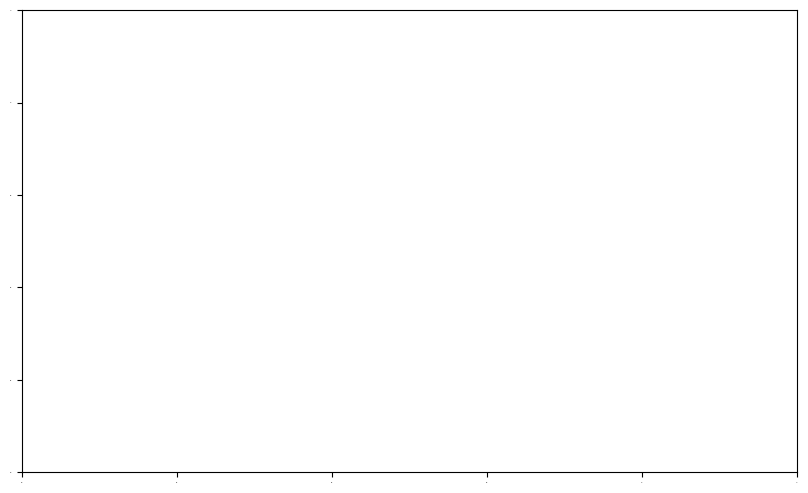

In [440]:
plt.figure(figsize=(10,6))
plt.scatter(pop_pca_trans[0],pop_pca_trans[1],c=pop['artist'], edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

In [443]:
pop.columns.to_list()

['artist',
 'album',
 'song',
 'lyrics',
 'cleaned_lyrics',
 'Segment',
 'WC',
 'Analytic',
 'Clout',
 'Authentic',
 'Tone',
 'WPS',
 'BigWords',
 'Dic',
 'Linguistic',
 'function',
 'pronoun',
 'ppron',
 'i',
 'we',
 'you',
 'shehe',
 'they',
 'ipron',
 'det',
 'article',
 'number',
 'prep',
 'auxverb',
 'adverb',
 'conj',
 'negate',
 'verb',
 'adj',
 'quantity',
 'Drives',
 'affiliation',
 'achieve',
 'power',
 'Cognition',
 'allnone',
 'cogproc',
 'insight',
 'cause',
 'discrep',
 'tentat',
 'certitude',
 'differ',
 'memory',
 'Affect',
 'tone_pos',
 'tone_neg',
 'emotion',
 'emo_pos',
 'emo_neg',
 'emo_anx',
 'emo_anger',
 'emo_sad',
 'swear',
 'Social',
 'socbehav',
 'prosocial',
 'polite',
 'conflict',
 'moral',
 'comm',
 'socrefs',
 'family',
 'friend',
 'female',
 'male',
 'Culture',
 'politic',
 'ethnicity',
 'tech',
 'Lifestyle',
 'leisure',
 'home',
 'work',
 'money',
 'relig',
 'Physical',
 'health',
 'illness',
 'wellness',
 'mental',
 'substances',
 'sexual',
 'food',
 'd

In [444]:
# smaller scale version
# Create a list of columns that start with "nrc_"
nrc_columns = [col for col in pop.columns if col.startswith("nrc_")] + ["Linguistic", "Analytic", "Authentic", "Tone","emo_pos", "emo_neg", "artist", "lyrics", 'Narrativity_Overall',
 'Narrativity_Staging',
 'Narrativity_PlotProg',
 'Narrativity_CogTension',
 'Staging_1',
 'Staging_2',
 'Staging_3',
 'Staging_4',
 'Staging_5',
 'PlotProg_1',
 'PlotProg_2',
 'PlotProg_3',
 'PlotProg_4',
 'PlotProg_5',
 'CogTension_1',
 'CogTension_2',
 'CogTension_3',
 'CogTension_4',
 'CogTension_5',]
               

# Filter DataFrame to keep only "nrc_" columns
pop_small = pop[nrc_columns]


# Process the entire column in batch (more efficient than applying row by row)
predictions_sm = emotion_model(pop_small['lyrics'].tolist(), batch_size=8)

print(predictions_sm[:3])

[{'label': 'fear', 'score': 0.2581448554992676}, {'label': 'joy', 'score': 0.516924262046814}, {'label': 'anger', 'score': 0.7172018885612488}]


In [445]:
pop_small.columns


Index(['nrc_trust', 'nrc_anticipation', 'nrc_fear', 'nrc_surprise',
       'nrc_negative', 'nrc_disgust', 'nrc_sadness', 'nrc_joy', 'nrc_positive',
       'nrc_anger', 'Linguistic', 'Analytic', 'Authentic', 'Tone', 'emo_pos',
       'emo_neg', 'artist', 'lyrics', 'Narrativity_Overall',
       'Narrativity_Staging', 'Narrativity_PlotProg', 'Narrativity_CogTension',
       'Staging_1', 'Staging_2', 'Staging_3', 'Staging_4', 'Staging_5',
       'PlotProg_1', 'PlotProg_2', 'PlotProg_3', 'PlotProg_4', 'PlotProg_5',
       'CogTension_1', 'CogTension_2', 'CogTension_3', 'CogTension_4',
       'CogTension_5'],
      dtype='object')

In [455]:
pop_small.loc[:, "row_id"] = pop_small.groupby(["artist", "lyrics"]).ngroup()


In [456]:
# Extract only the emotion label from each prediction
pop_small['emotion'] = [pred['label'] for pred in predictions_sm]  # Extract emotion labels
pop_small['emotion_score'] = [pred['score'] for pred in predictions_sm]  # Extract confidence scores



/var/folders/g1/9qqnjd1x21dbm_sdrj7lhrlw0000gn/T/ipykernel_37841/3572578106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_small['emotion'] = [pred['label'] for pred in predictions_sm]  # Extract emotion labels
/var/folders/g1/9qqnjd1x21dbm_sdrj7lhrlw0000gn/T/ipykernel_37841/3572578106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_small['emotion_score'] = [pred['score'] for pred in predictions_sm]  # Extract confidence scores


In [461]:
# pivot wider:
pop_small_exp = pop_small.pivot_table(
    index=["artist", "lyrics"] + [col for col in pop_small.columns if col.startswith("nrc_") or col in ["Linguistic", "Analytic", "Authentic", "Tone","emo_pos", "emo_neg", 'Narrativity_Overall',
 'Narrativity_Staging',
 'Narrativity_PlotProg',
 'Narrativity_CogTension',
 'Staging_1',
 'Staging_2',
 'Staging_3',
 'Staging_4',
 'Staging_5',
 'PlotProg_1',
 'PlotProg_2',
 'PlotProg_3',
 'PlotProg_4',
 'PlotProg_5',
 'CogTension_1',
 'CogTension_2',
 'CogTension_3',
 'CogTension_4',
 'CogTension_5']],
    columns="emotion",
    values="emotion_score",
    aggfunc="mean"  # or 'max', 'min', 'first', etc.
).reset_index()



In [462]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_sm_scale =  pop_small_exp.select_dtypes(include='number').fillna(0)
scl2 = pd.DataFrame(scaler.fit_transform(pop_sm_scale)) 



In [463]:
scl2.columns = pop_sm_scale.columns
scl2.head()


emotion  nrc_trust  nrc_anticipation  nrc_fear  nrc_surprise  nrc_negative  \
0         0.901118         -0.394783  0.540273     -0.228645      0.649106   
1        -0.298663         -0.028486  0.160743     -0.228645     -0.075034   
2         1.261052          0.337811 -0.408553     -0.536982     -0.733344   
3        -0.538619          0.093613  2.058393     -0.691151      2.229049   
4         0.781140          0.826207  0.919803     -0.382813     -0.140865   

emotion  nrc_disgust  nrc_sadness   nrc_joy  nrc_positive  nrc_anger  ...  \
0           0.677266    -0.040073 -0.377171     -0.473905   0.838511  ...   
1           0.468877    -0.147992 -0.278680     -0.241776   0.157515  ...   
2          -0.677266    -0.903423  0.213779     -0.009646  -0.693731  ...   
3           0.989851     2.442058 -1.066613      0.764118   0.327764  ...   
4           0.156292    -0.363829  1.297188      1.151000   0.498013  ...   

emotion  CogTension_3  CogTension_4  CogTension_5     anger   disgust  \
0            1.310031     -1.133541     -1.006908 -0.652050 -0.189903   
1           -1.179515      0.531002     -0.162406  0.646929 -0.189903   
2            0.480265     -1.133541      1.503501 -0.652050 -0.189903   
3            0.058287     -1.133541     -0.371272 -0.652050 -0.189903   
4           -1.179515     -1.133541      1.503501  0.990444 -0.189903   

emotion      fear       joy   neutral   sadness  surprise  
0       -0.398751 -0.150641 -0.621451  2.030293 -0.184347  
1       -0.398751 -0.150641 -0.621451 -0.345703 -0.184347  
2       -0.398751 -0.150641  1.692688 -0.345703 -0.184347  
3        2.998504 -0.150641 -0.621451 -0.345703 -0.184347  
4       -0.398751 -0.150641 -0.621451 -0.345703 -0.184347  

[5 rows x 42 columns]

[pca] >Extracting column labels from dataframe.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [42] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


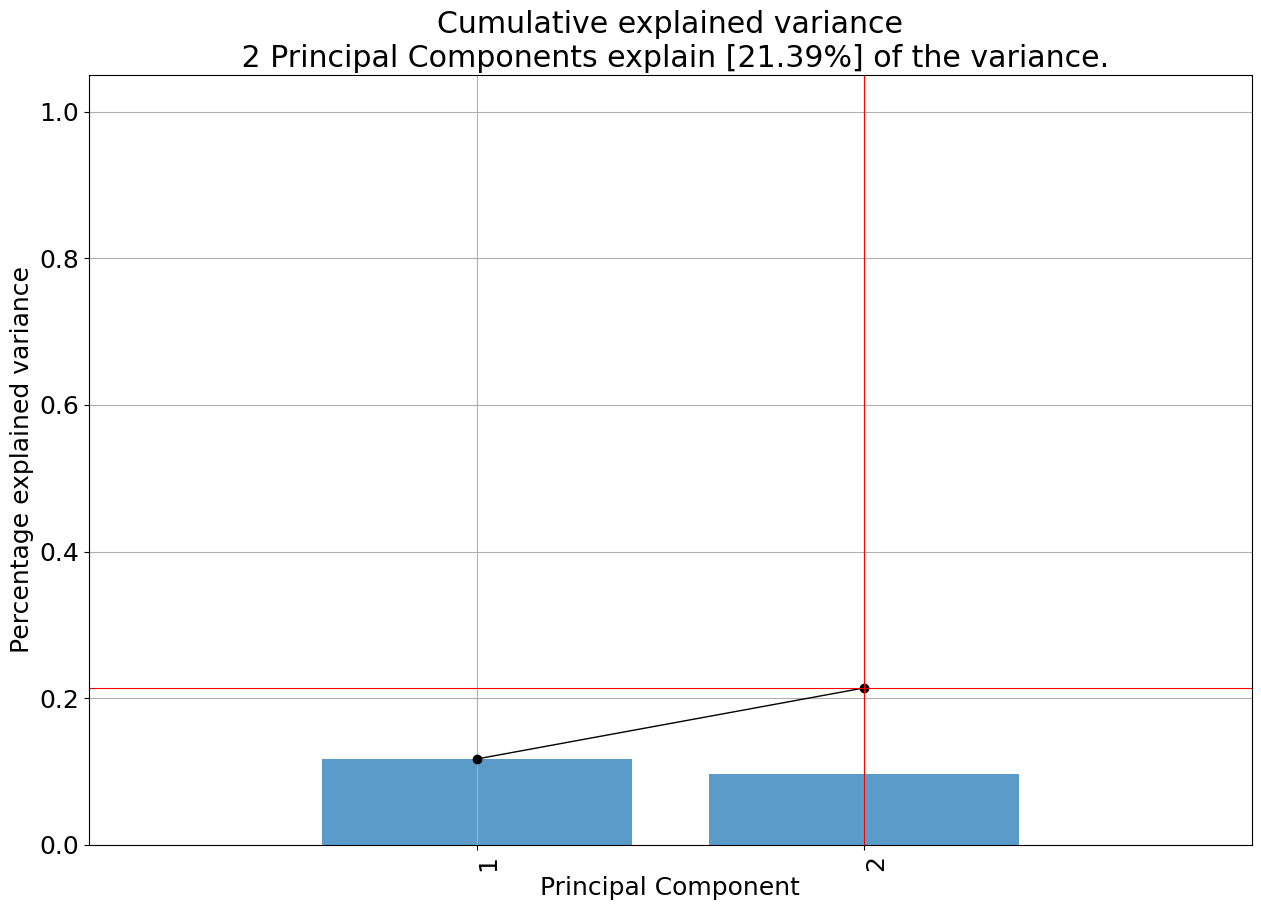

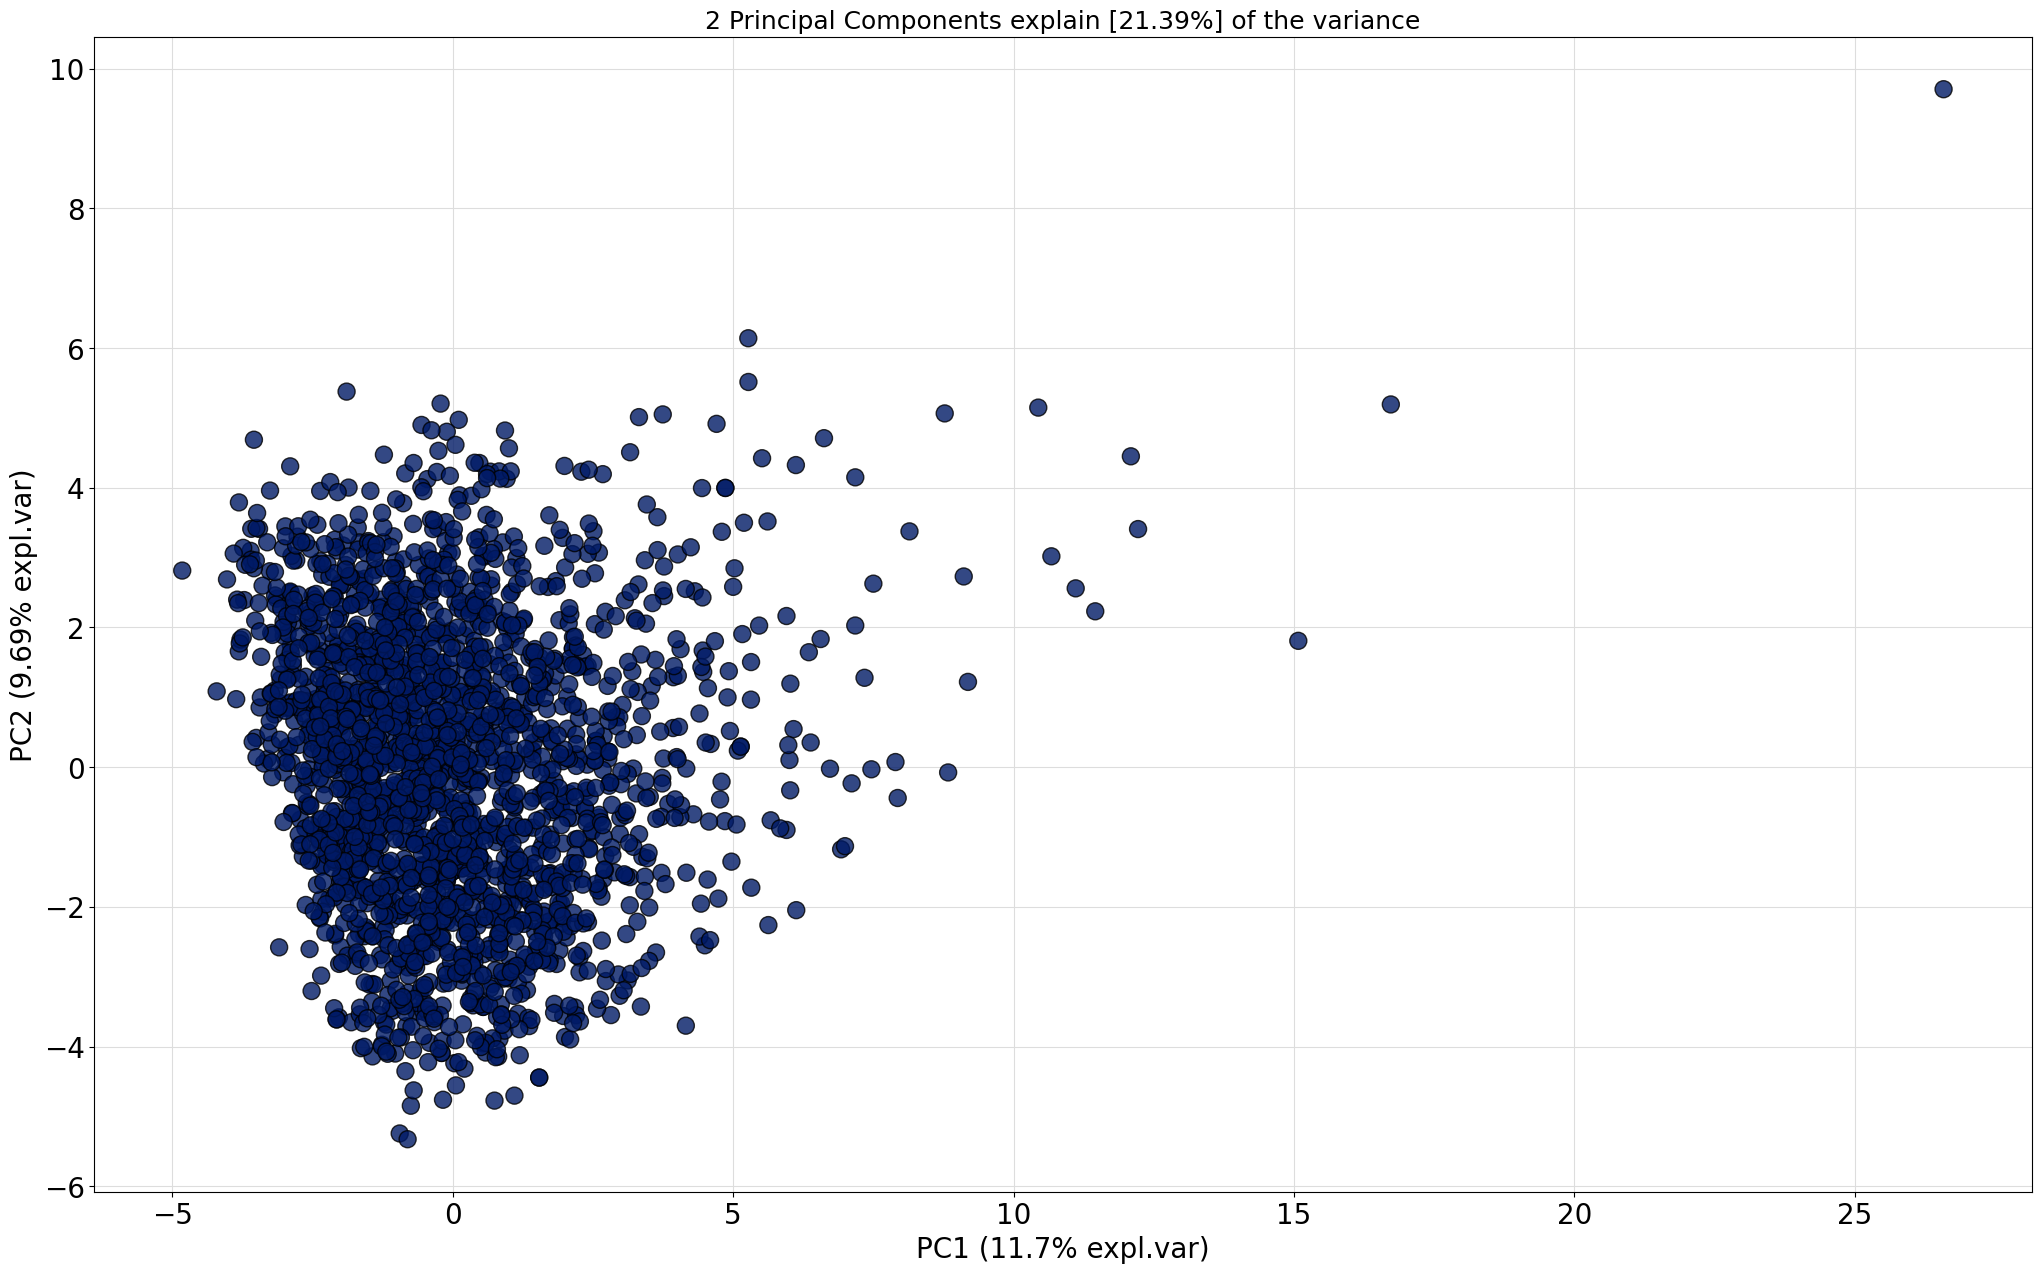

In [464]:
from pca import pca
#model2 = pca(n_components=0.95)
# ... or explicitly specify the number of PCs
model2 = pca(n_components=2)

# Fit and transform
results = model2.fit_transform(X=scl2, row_labels = pop_small["artist"])

# Plot the explained variance
fig, ax = model2.plot()

# Scatter the first two PCs
fig, ax = model2.scatter()


In [465]:
pop_small_exp.shape

(2246, 44)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


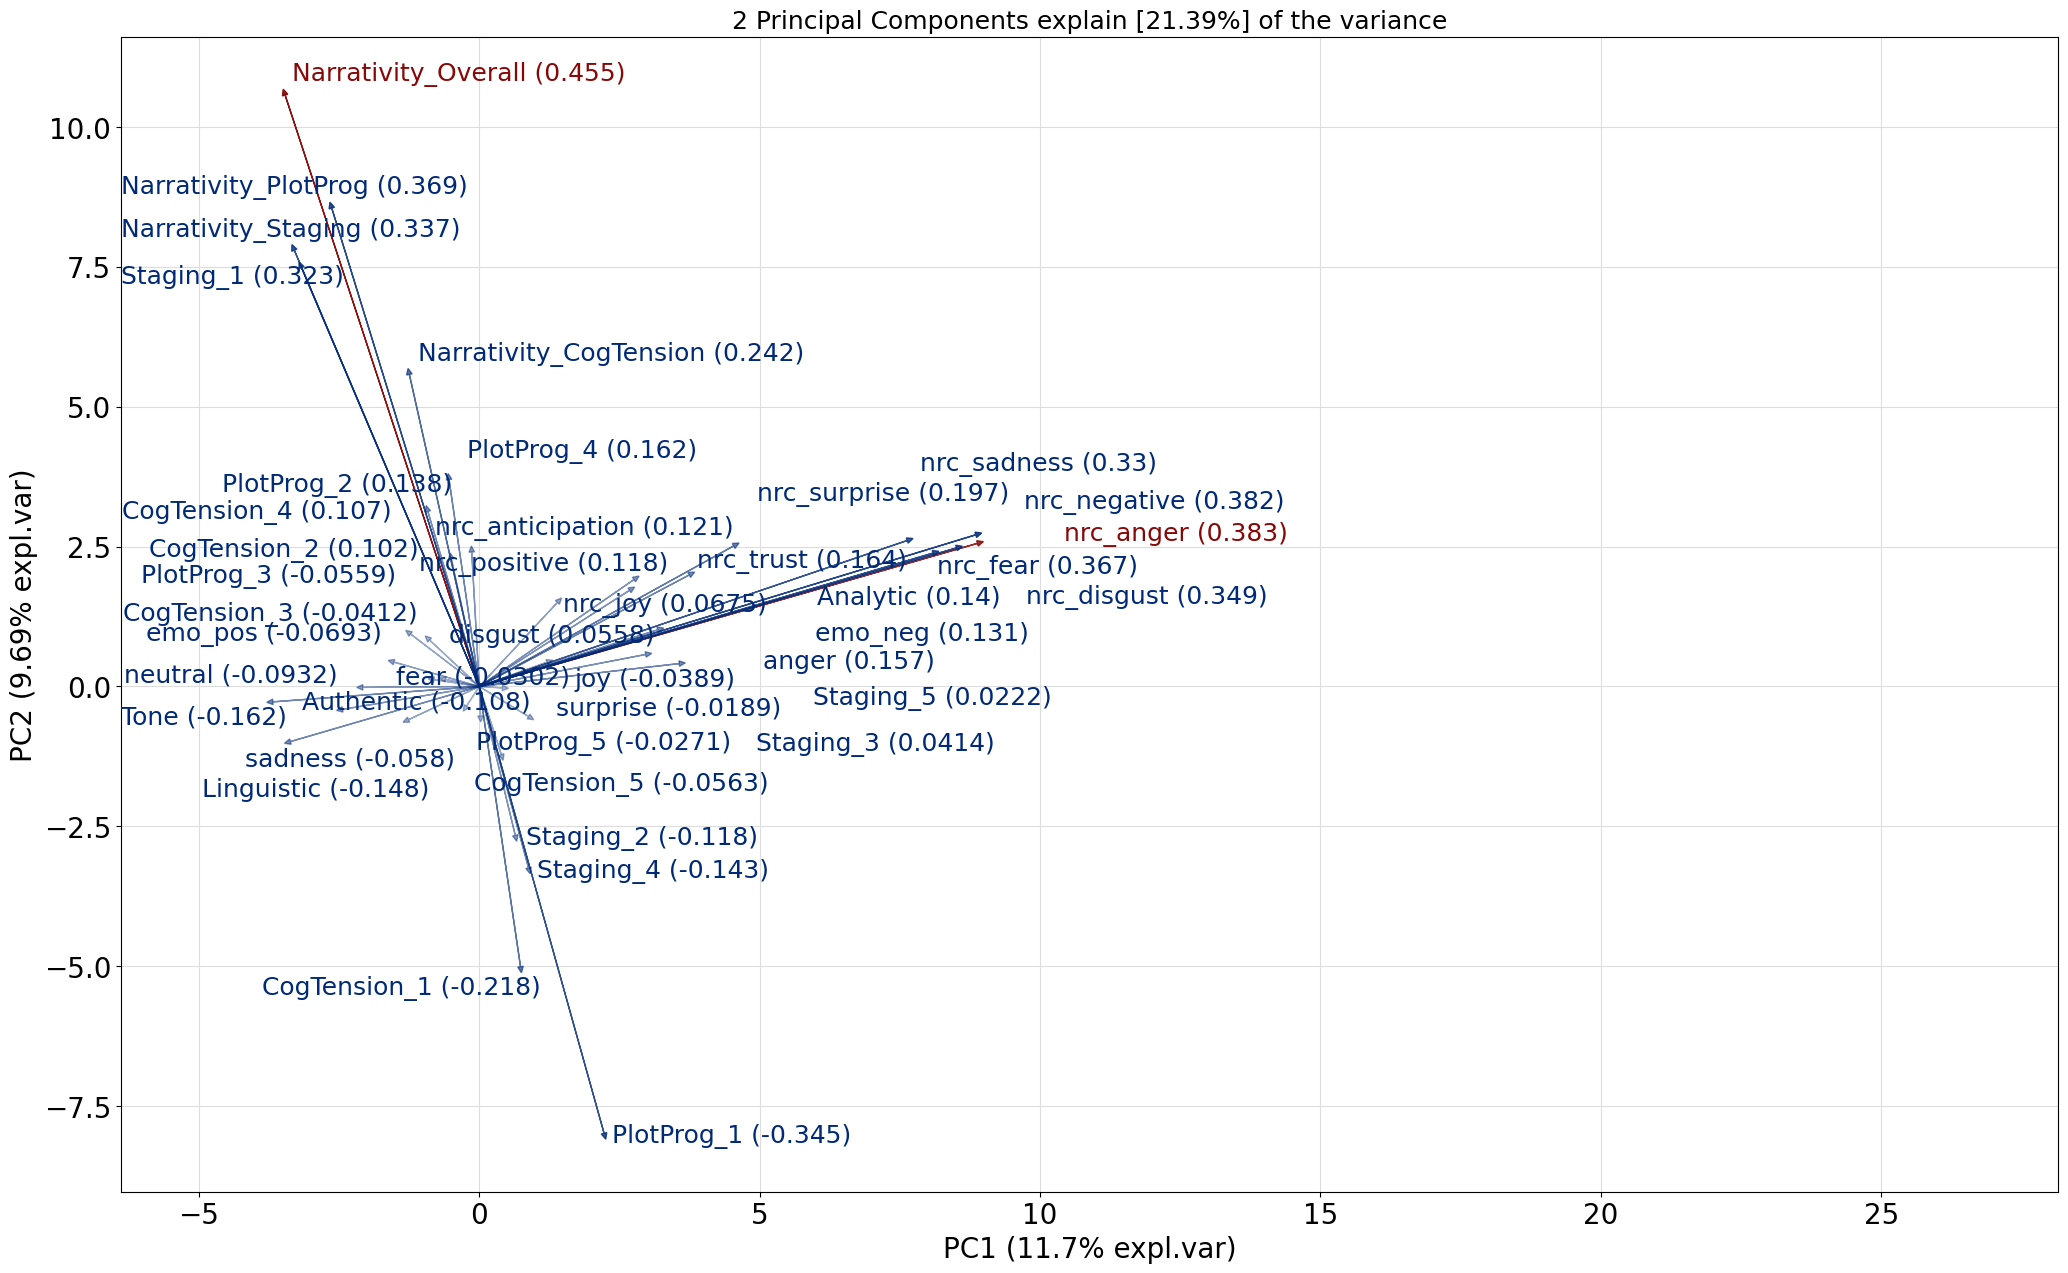

In [466]:
# Create a biplot
fig, ax = model2.biplot(n_feat=44, cmap=None)

In [467]:
pop_small_exp.columns

Index(['artist', 'lyrics', 'nrc_trust', 'nrc_anticipation', 'nrc_fear',
       'nrc_surprise', 'nrc_negative', 'nrc_disgust', 'nrc_sadness', 'nrc_joy',
       'nrc_positive', 'nrc_anger', 'Linguistic', 'Analytic', 'Authentic',
       'Tone', 'emo_pos', 'emo_neg', 'Narrativity_Overall',
       'Narrativity_Staging', 'Narrativity_PlotProg', 'Narrativity_CogTension',
       'Staging_1', 'Staging_2', 'Staging_3', 'Staging_4', 'Staging_5',
       'PlotProg_1', 'PlotProg_2', 'PlotProg_3', 'PlotProg_4', 'PlotProg_5',
       'CogTension_1', 'CogTension_2', 'CogTension_3', 'CogTension_4',
       'CogTension_5', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness',
       'surprise'],
      dtype='object', name='emotion')

In [499]:
pop_four = pop_small_exp[['Narrativity_Overall', 'PlotProg_1', 'emo_pos', 'anger', 'joy']]

In [502]:
# now LIWC, NRC, distilbert all together : time for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pop_four_scale =  pop_four.select_dtypes(include='number').fillna(0)
scl3 = pd.DataFrame(scaler.fit_transform(pop_four_scale)) 

scl3.columns = pop_four_scale.columns
scl3.head()

emotion  Narrativity_Overall  PlotProg_1   emo_pos     anger       joy
0                  -1.107091   -0.545618 -0.431221 -0.652050 -0.150641
1                   0.044071    1.383466 -0.550209  0.646929 -0.150641
2                  -0.293745   -0.374394  0.031513 -0.652050 -0.150641
3                  -0.310223    0.608371 -0.675808 -0.652050 -0.150641
4                  -0.515031    0.320988 -0.332063  0.990444 -0.150641

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


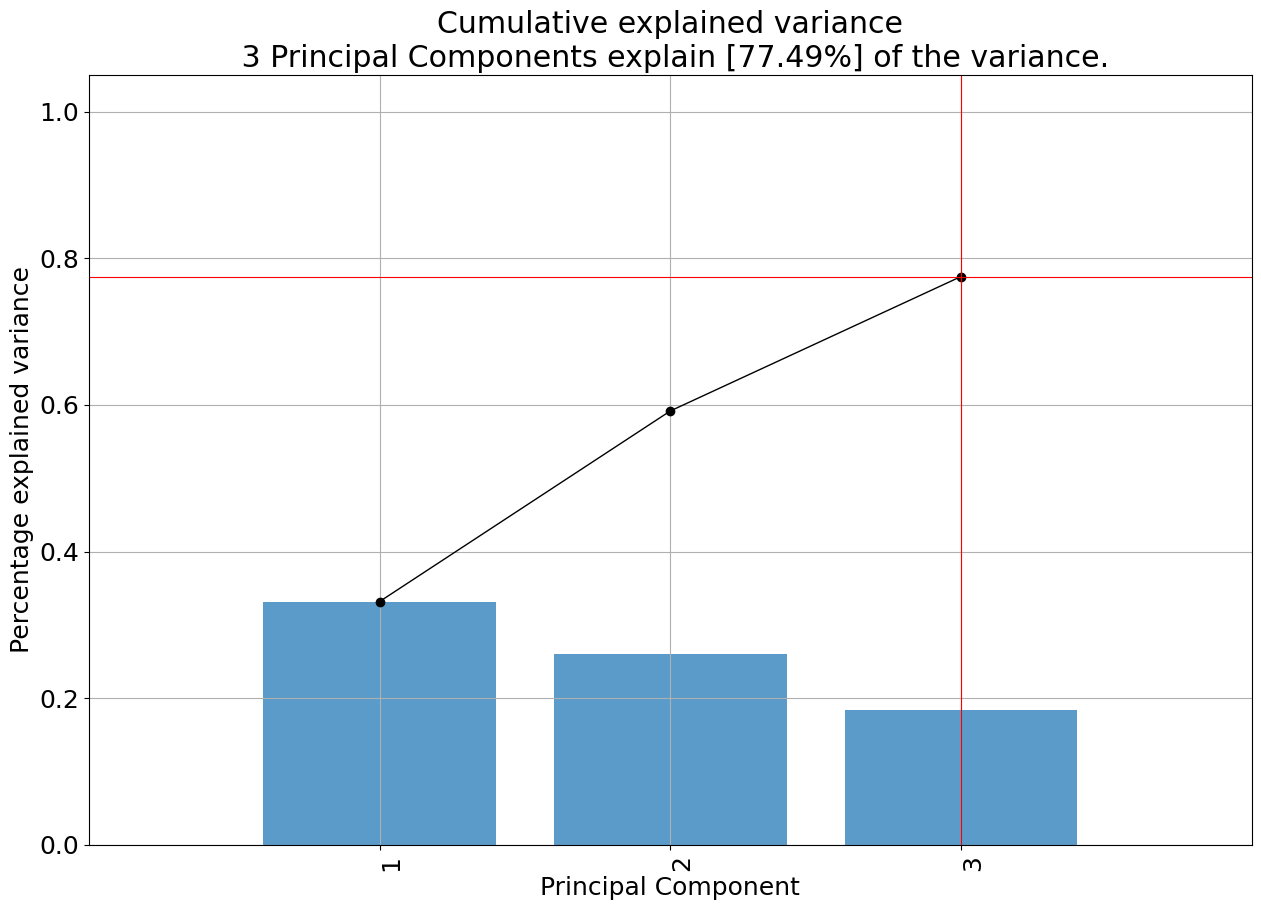

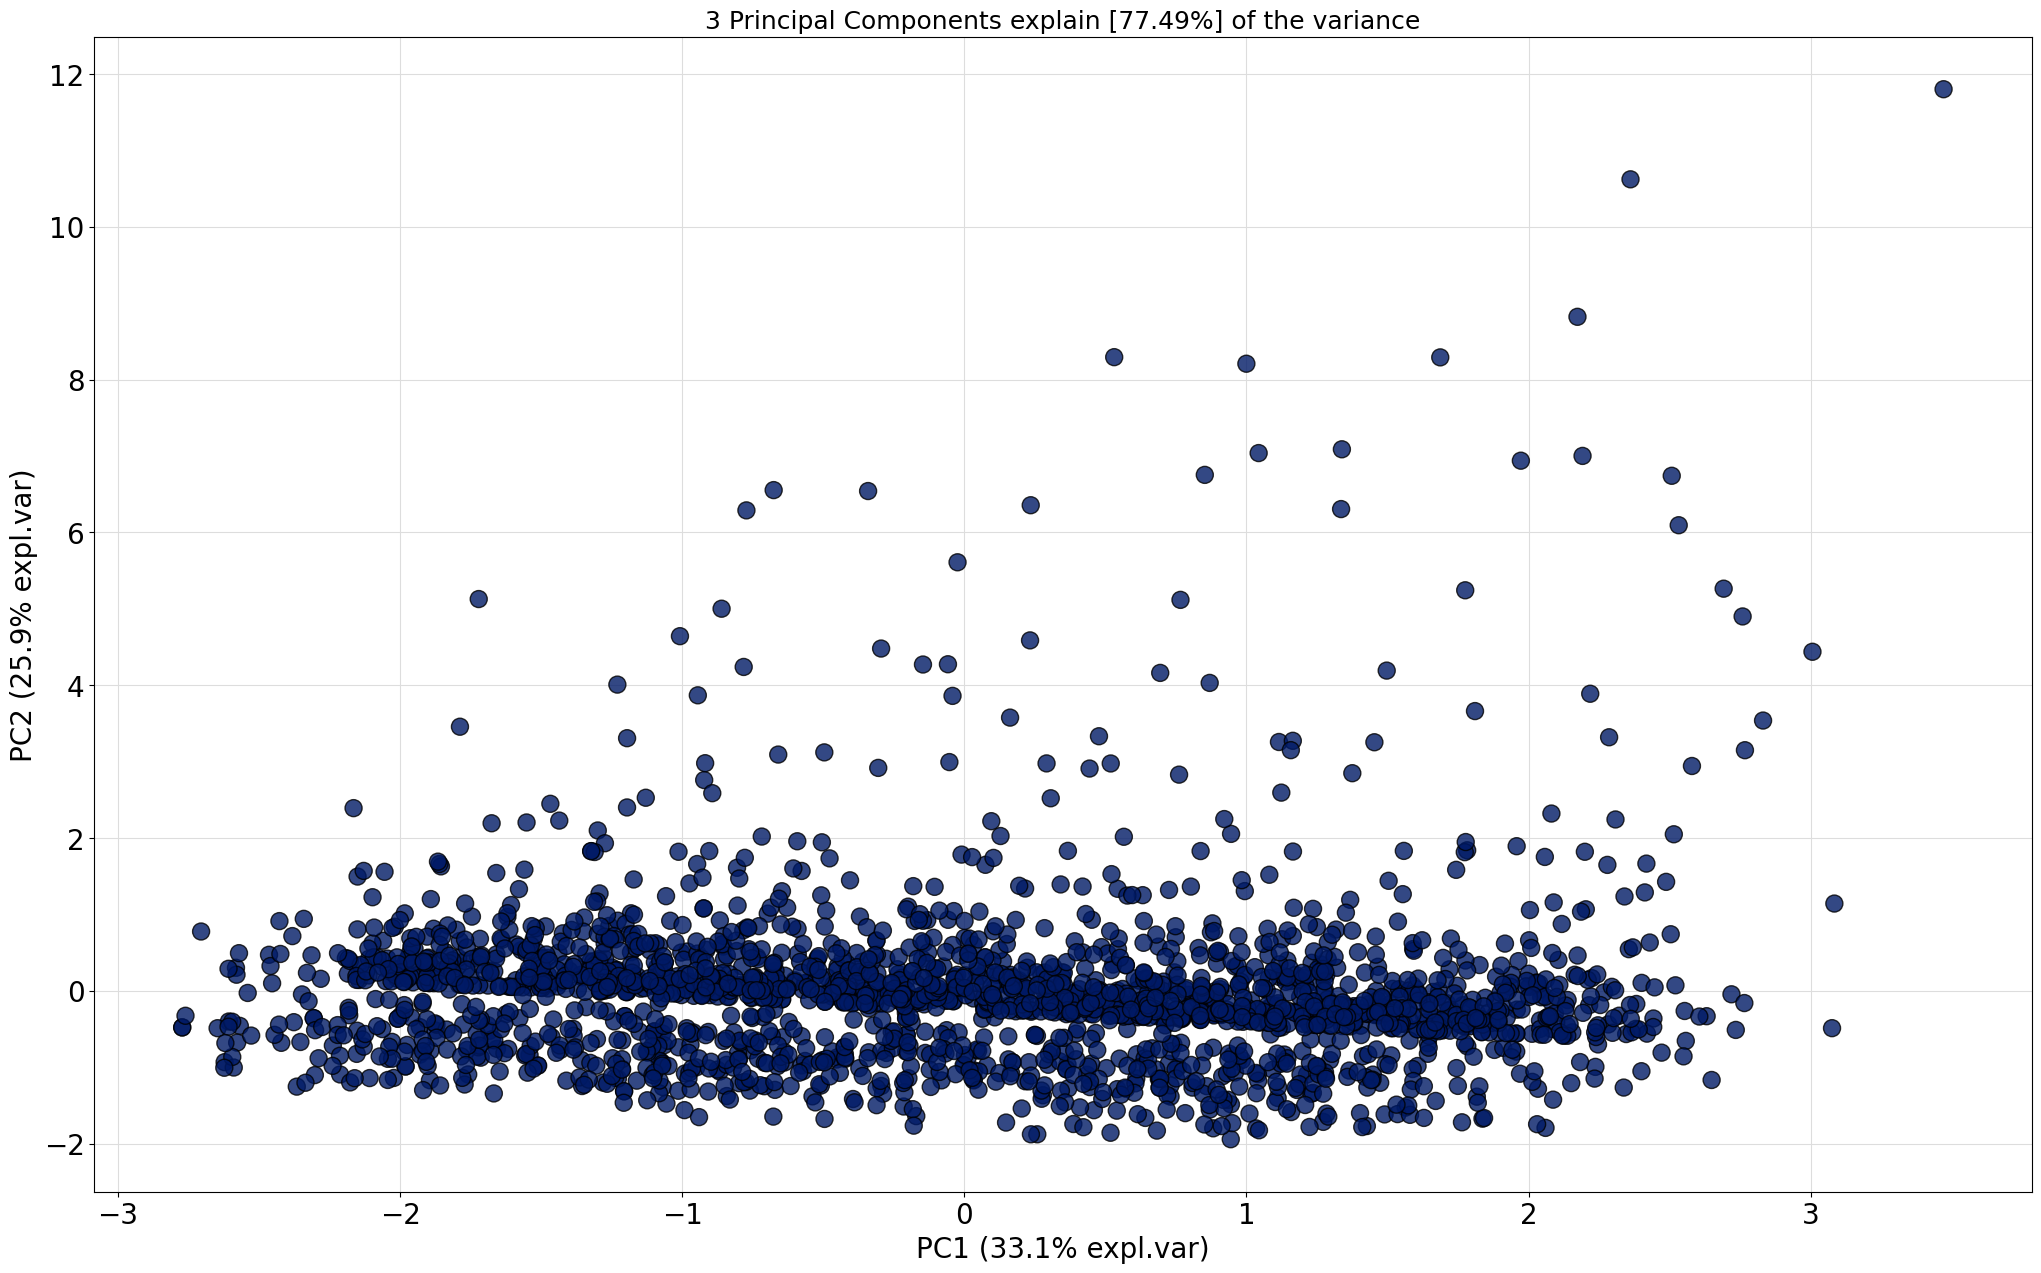

In [505]:
from pca import pca

# ... or explicitly specify the number of PCs
model3 = pca(n_components=3)

# Fit and transform
results = model3.fit_transform(X=scl3)

# Plot the explained variance
fig, ax = model3.plot()

# Scatter the first two PCs
fig, ax = model3.scatter()

In [506]:
# Scatter the first two PCs
#fig, ax = model3.scatter()
# for artist, group in model3.groupby('artist'):
#     ax.scatter(group['x'], group['y'], label=artist)

# ax.legend()
# plt.show()


[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


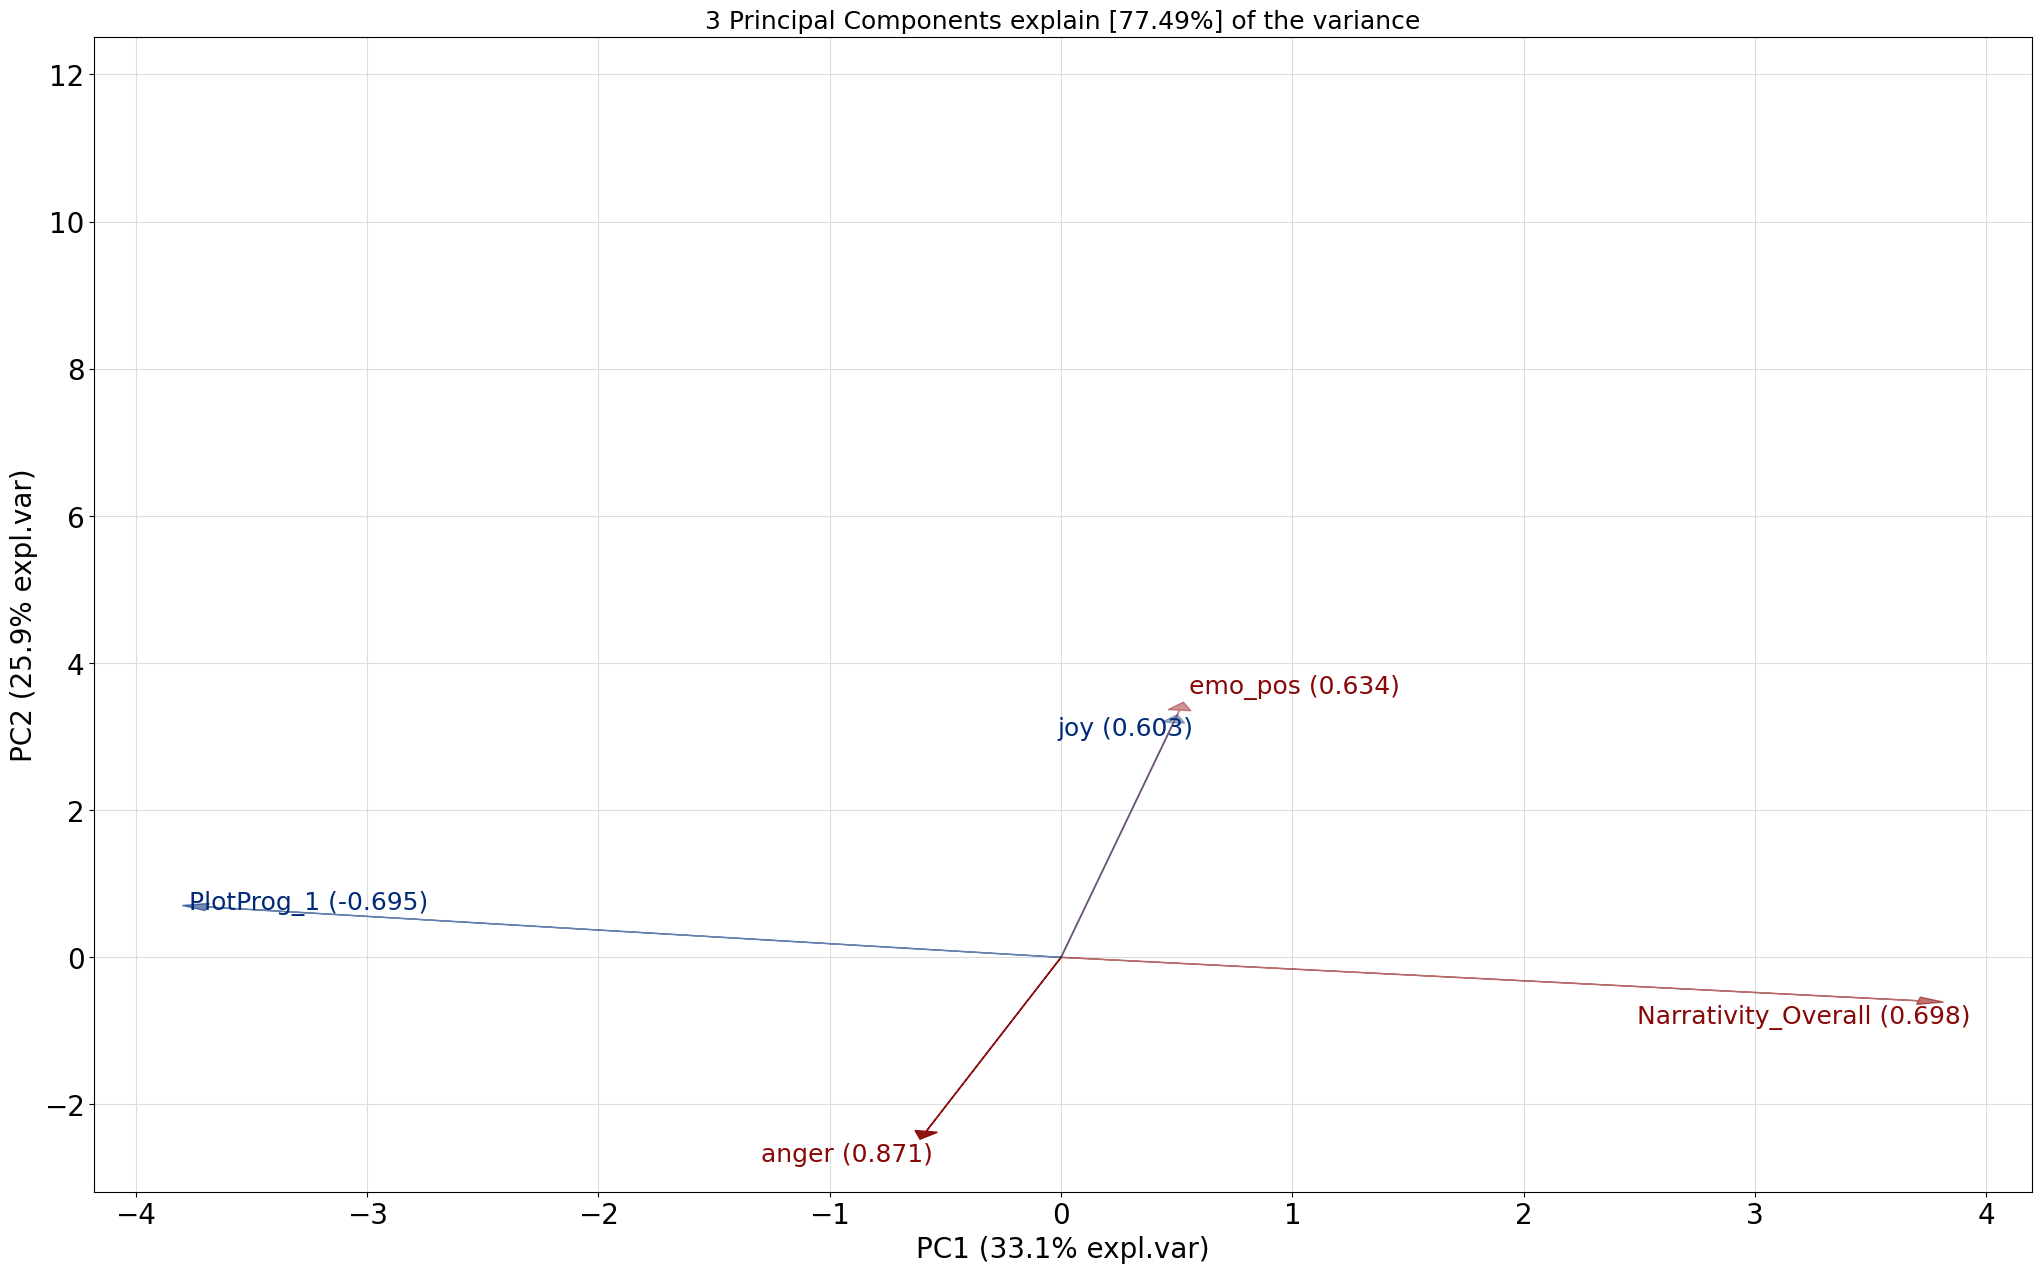

In [507]:
# Create a biplot
fig, ax = model3.biplot(n_feat=17, cmap=None)

In [520]:
# bring in lastfm data
import json

parada= pd.json_normalize([json.loads(line) for line in open('data/parada_full_dataset.json')])




In [521]:
#
parada.head()

popularity  lfm_playcount genre  _id.artist          _id.track  \
0         303           1442   pop   Parachute            Halfway   
1        2522            261   pop  Charli XCX    !Franchesckaar!   
2         136            115   pop       Slade  She's Got the Lot   
3         479             51   pop        TISM   !UOY Sevol Natas   
4       20002             30   rap        Russ              Shots   

          release.$date  features.compression_ratio  features.entropy  \
0  2011-05-17T00:00:00Z                    3.498047          3.793008   
1  2008-08-18T00:00:00Z                    3.936407          3.691611   
2  1977-03-21T00:00:00Z                    2.673203          4.236022   
3  1995-05-01T00:00:00Z                    1.912150          4.389914   
4  2020-01-31T00:00:00Z                    2.394048          4.564569   

   features.uncommon_words_ratio  features.readability.flesch_kincaid_grade  \
0                            1.0                                      141.7   
1                            1.0                                       -0.4   
2                            1.0                                       91.4   
3                            1.0                                       11.5   
4                            1.0                                      151.0   

   ...  affective.LIWC.tentat  affective.LIWC.they  affective.LIWC.time  \
0  ...               3.243243             0.000000             3.783784   
1  ...               0.253165            11.392405             1.265823   
2  ...               4.184100             0.836820             0.418410   
3  ...               2.197802             4.395604             2.197802   
4  ...               1.515152             1.010101             7.070707   

   affective.LIWC.total_word_count  affective.LIWC.verb  affective.LIWC.we  \
0                            369.0            38.648649           0.000000   
1                            394.0            16.455696           0.000000   
2                            238.0            23.849372           0.000000   
3                            181.0            19.230769           0.000000   
4                            395.0            23.232323           0.505051   

   affective.LIWC.work  affective.LIWC.you  affective.LabMT.happiness  \
0             0.270270           12.702703                   0.050938   
1             1.518987           13.417722                   0.248339   
2             0.000000            1.673640                   0.158898   
3             1.098901           10.989011                   0.156229   
4             0.000000            2.272727                   0.060010   

   release.$date.$numberLong  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  

[5 rows x 216 columns]

In [522]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
parada_scale =  parada.select_dtypes(include='number').fillna(0)
scl2 = pd.DataFrame(scaler.fit_transform(parada_scale)) 

In [ ]:
scl2.columns = parada_scale.columns

from pca import pca
#model2 = pca(n_components=0.95)
# ... or explicitly specify the number of PCs
model_lm = pca(n_components=2)

# Fit and transform
results_lm = model_lm.fit_transform(X=scl2, row_labels = pop_small["artist"])

# Plot the explained variance
fig, ax = model_lm.plot()

# Scatter the first two PCs
fig, ax = model_lm.scatter()

[pca] >Extracting column labels from dataframe.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [206] columns of the input dataframe.
[pca] >Fit using PCA.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Exten

In [ ]:
# Create a biplot
fig, ax = model_lm.biplot(n_feat=216, cmap=None)